In [1]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import random

## Preprocessing and feature engineering

In [79]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()
songs.columns = ['user_id', 'artistname','trackname','playlistname']

In [80]:
display(songs.shape)
display(songs['trackname'].nunique())

(12867139, 4)

2009210

In [81]:
print(songs[songs['artistname'] == 'Pink Floyd'].trackname[0:20].to_string())

896                                         Sorrow - Live
1057                                     Comfortably Numb
1058                              Comfortably Numb - Live
1098                     Echoes - 2011 Remastered Version
1099                    Eclipse - 2011 Remastered Version
1186                                       Hey You - Live
1187                                    High Hopes - Live
1414                    Shine On You Crazy Diamond - Live
1554     Welcome To The Machine - 2011 Remastered Version
1568                 Wish You Were Here - 2011 - Remaster
4193               Brain Damage - 2011 Remastered Version
5123               Echoes - Edit; 2001 Remastered Version
5353                   Fearless - 2011 Remastered Version
7647                      Money - 2011 Remastered Version
10929                                  Wish You Were Here
10930                Wish You Were Here - 2011 - Remaster
11229              Brain Damage - 2011 Remastered Version
12235         

In [82]:
#Every artist can have only one version of the song, reduces unique songs from 2009210 to 1367548

def preprocess_track(trackname):

    trackname = trackname.lower()
    
    # everything between [], () is often live remaster etc.
    trackname = re.sub("[\(\[].*?[\)\]]", "", trackname)
        
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #Remove empty spaces around the trackname
    trackname = trackname.strip()     
       
    return trackname

In [83]:
songs['trackname'] = songs['trackname'].copy().apply(preprocess_track)
#Alternatively only song names to lowercase
#songs['trackname'] = songs['trackname'].map(lambda x: x.lower())
songs['artistname'] = songs['artistname'].map(lambda x: x.lower())

In [84]:
#uniques after preprocessing
songs['trackname'].nunique()

1367548

In [85]:
print(songs[songs['artistname'] == 'pink floyd'].trackname[0:20].to_string())

896                          sorrow
1057               comfortably numb
1058               comfortably numb
1098                         echoes
1099                        eclipse
1186                        hey you
1187                     high hopes
1414     shine on you crazy diamond
1554         welcome to the machine
1568             wish you were here
4193                   brain damage
5123                         echoes
5353                       fearless
7647                          money
10929            wish you were here
10930            wish you were here
11229                  brain damage
12235                         money
12809                         money
28819                one of the few


In [87]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between same named songs from different artist (meta2prodvec)
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]


In [86]:
songs.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,red shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"peace, love and understanding",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,HARD ROCK 2010


In [88]:
#large increase in unique songs when artist names added to song name
songs['trackartist'].nunique()

2342855

In [89]:
frequency_of_songs = songs.groupby('trackartist').count()['user_id']
sorted_frequencies = frequency_of_songs.sort_values(ascending=False)

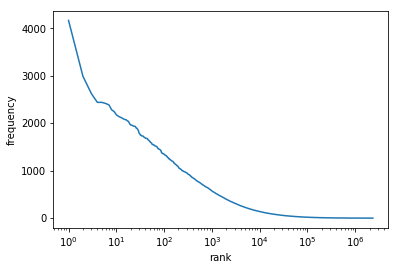

In [90]:
plt.plot(np.arange(1,2342856),sorted_frequencies[0:2342855])
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')

plt.show()

In [91]:
#min count hyperparameter 5 chosen to take into the model most of the songs 
display(np.sum(sorted_frequencies[0:400000]))
display(sorted_frequencies[400000])

9837229

5

In [92]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [93]:
display(playlists.head())
display(playlists.shape)

,trackartist
userplaylist,
00055176fea33f6e027cd3302289378b - favs,"[jannik brunke - 18, green day - 21 guns, shaw..."
0007f3dd09c91198371454c608d47f22 - Fav songs,"[bryan adams - i do it for you, colourshop - 2..."
000b0f32b5739f052b9d40fcc5c41079 - Contacta,"[veronica maggio - bas gillar hörn, titiyo - b..."
000b0f32b5739f052b9d40fcc5c41079 - Gospel,"[the worship crew - brighter day, oslo gospel ..."
000b0f32b5739f052b9d40fcc5c41079 - Starred,"[java gospel - a blessed christmas eve, java g..."


(188437, 1)

In [95]:
def playlist_format(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [98]:
playlist_formatted = playlist_format(playlists)
playlist_length = len(playlist_formatted)
print(playlist_length)

188437


### UCI online retail data set

In [2]:
#http://archive.ics.uci.edu/ml/datasets/Online+Retail

In [3]:
retail = pd.read_excel('Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
retail['Description'].nunique()

4223

In [11]:
retail_grouped = retail.groupby('InvoiceNo')['Description'].apply(list)

In [12]:
len(retail_grouped)

25900

In [13]:
retail_grouped = pd.DataFrame(retail_grouped)
retail_grouped = retail_grouped[retail_grouped['Description'].str.len() >= 10]

In [14]:
len(retail_grouped)

13167

In [15]:
def shopping_basket_format(baskets):
    baskets_formatted = []
    for index, row in baskets.iterrows():
        baskets_formatted.append(row[0])

    return baskets_formatted 

In [16]:
baskets = shopping_basket_format(retail_grouped)
baskets_length = len(baskets)

## Training Word2vec-music recommender

In [10]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
np.random.seed(0)

In [118]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
#train/test split for spotify playlist
index = np.random.choice(range(playlist_length), playlist_length, replace=False)
train = np.array(playlist_formatted)[index[:int(playlist_length * 0.8)]].tolist()
test = np.array(playlist_formatted)[index[int(playlist_length * 0.8):]].tolist()

In [110]:
#train/test split for shopping baskets
index = np.random.choice(range(baskets_length), baskets_length, replace=False)
train = np.array(baskets)[index[:int(baskets_length * 0.8)]].tolist()
test = np.array(baskets)[index[int(baskets_length * 0.8):]].tolist()

In [17]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

### Evaluation

In [18]:
def test_HR_and_NDGC_single_item(playlist, index, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    query = playlist[index]
    word = playlist[index+1]
    try:
        res = model.wv.most_similar(positive=query, topn=k)
        for i in range(k):
            if res[i][0] == word:
                hits += 1
                ndgc += 1/(math.log2(i+1))
        tries += 1
    except:
        fails += 1
        #print(query + " was not found in vocab")
    return (hits, ndgc, tries, fails)

# slow and not same task as in the paper 
def test_HR_and_NDGC_whole_test_set(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        #ind = random.randrange(len(playlist)-1)
        for ind in range(len(playlist)-1):
            hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
            hits+=hi
            ndgc+=nd
            tries+=tr
            fails+=fa
    return (hits, ndgc, tries, fails)

def test_HR_and_NDGC_one_task_per_playlist(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        ind = random.randrange(len(playlist)-1)
        hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
        hits+=hi
        ndgc+=nd
        tries+=tr
        fails+=fa
    return (hits, ndgc, tries, fails)

### Gridsearch

In [119]:
def grid_search(*iterables):
    #create all combinations of input values
    return np.array(np.meshgrid(*iterables)).T.reshape(-1,len(iterables))

workers = 12
k=10 #predicted items

window_options = [3, 5, 7, 9] #window size L
it_options = [100] #epochs n
sample_options = [0.1, 0.001, 0.00001] #sub-sampling t 
negative_sampling_dist = [-0.5, 0.75] # negative sampling distribution parameter a

size_embedding_options = [50] # embedding size
neg_options = [5] #negative samples amount
alpha = [0.025] # learning rate
min_count_options = [5] #words under this are ignored
   
hyperparameters = []
hit_ratios = []
NDCG = []
best_model = None

for (n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count) in \
        grid_search(window_options, it_options, sample_options, negative_sampling_dist, size_embedding_options,
                    neg_options, alpha,min_count_options):
    hyperparameters.append([n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count])
    print('Using following hyperparameters: ', hyperparameters[-1])
    model = gensim.models.Word2Vec(train, size=int(n_size), window=int(n_window),
                 min_count=int(n_min_count), workers=workers, sg=1, iter=int(n_it),
                 sample=n_sample, negative=int(n_neg), ns_exponent=n_neg_sample_dist, alpha=n_alpha)
    
    model.train(train,total_examples=len(train), epochs=model.iter)
    hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
    hit_ratio = hits/tries
    if hit_ratios and hit_ratio > max(accuracies):
        best_model = model
    hit_ratios.append(hits/tries)
    NDCG.append(ndgc/tries)
    print('Accuracy (hit_ratio) values for parameters:', hits/tries)
    print('NDCG values for parameters:', ndgc/tries)

Using following hyperparameters:  [3.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


C:\Users\Simo\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Accuracy (hit_ratio) values for parameters: 0.16155904858833728
NDCG values for parameters: 0.05875361476615765
Using following hyperparameters:  [5.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy (hit_ratio) values for parameters: 0.20172645309802417
NDCG values for parameters: 0.07137402013713369
Using following hyperparameters:  [7.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy (hit_ratio) values for parameters: 0.2327522615211399
NDCG values for parameters: 0.08301470962892005
Using following hyperparameters:  [9.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy (hit_ratio) values for parameters: 0.25168073796122575
NDCG values for parameters: 0.09064043837740184
Using following hyperparameters:  [3.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy (hit_ratio) values for parameters: 0.16044213067753132
NDCG values for parameters: 0.05795462906276033
Using following hyperparameters:  [5.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy (hit_ratio) values for 

In [120]:
#print the combinations and their accuracy.
acc_and_hyper = list(map(list, zip(hit_ratios,NDCG, hyperparameters))) # [list(i) for i in zip(accuracies, hyperparameters)]
acc_and_hyper = list(map(lambda x: [x[0], x[1]] + x[2], acc_and_hyper))
acc_and_hyper.sort(key=lambda x: x[0])
acc_and_hyper = pd.DataFrame(acc_and_hyper)
acc_and_hyper.columns = ['hit-ratio','ndcq', 'window-size', 'epochs','sub-sample',
                         'negative-sampling-dist','embedding-size','negative-samples-size','learning-rate', 'mininum-count']

In [121]:
#spotify playlistss
display(acc_and_hyper.head())
display(acc_and_hyper.tail())

,hit-ratio,ndcq,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-size,learning-rate,mininum-count
0,0.160442,0.057955,3.0,100.0,0.00100,-0.50,50.0,5.0,0.025,5.0
1,0.161559,0.058754,3.0,100.0,0.10000,-0.50,50.0,5.0,0.025,5.0
2,0.168026,0.060252,3.0,100.0,0.00100,0.75,50.0,5.0,0.025,5.0
3,0.169926,0.060071,3.0,100.0,0.10000,0.75,50.0,5.0,0.025,5.0
4,0.172538,0.061218,3.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0


,hit-ratio,ndcq,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-size,learning-rate,mininum-count
19,0.251681,0.090640,9.0,100.0,0.10000,-0.50,50.0,5.0,0.025,5.0
20,0.251770,0.089071,9.0,100.0,0.00100,-0.50,50.0,5.0,0.025,5.0
21,0.261232,0.095461,9.0,100.0,0.00001,0.75,50.0,5.0,0.025,5.0
22,0.264830,0.096130,9.0,100.0,0.10000,0.75,50.0,5.0,0.025,5.0
23,0.265862,0.100040,9.0,100.0,0.00100,0.75,50.0,5.0,0.025,5.0


In [116]:
#shopping baskets
display(acc_and_hyper.head())
display(acc_and_hyper.tail())

,hit-ratio,ndcq,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-szie,learning-rate,mininum-count
0,0.279534,0.124237,7.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0
1,0.280118,0.115662,9.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0
2,0.281761,0.116823,7.0,100.0,0.00001,0.75,50.0,5.0,0.025,5.0
3,0.283812,0.120994,5.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0
4,0.289363,0.119947,5.0,100.0,0.00100,-0.50,50.0,5.0,0.025,5.0


,hit-ratio,ndcq,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-szie,learning-rate,mininum-count
19,0.332048,0.130985,7.0,100.0,0.001,0.75,50.0,5.0,0.025,5.0
20,0.332342,0.134964,5.0,100.0,0.001,0.75,50.0,5.0,0.025,5.0
21,0.332761,0.127913,3.0,100.0,0.001,-0.50,50.0,5.0,0.025,5.0
22,0.333759,0.137509,5.0,100.0,0.100,-0.50,50.0,5.0,0.025,5.0
23,0.351305,0.140980,3.0,100.0,0.001,0.75,50.0,5.0,0.025,5.0


In [122]:
#spotify playlists
acc_and_hyper.to_csv('hyperparameters/hyperparameters_spotify_playlist_k10_epochs100.csv')

In [117]:
#shopping baskets
acc_and_hyper.to_csv('hyperparameters/hyperparameters_shopping_basket_k10.csv')

### Example recommendations

In [135]:
#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - Bridge Over Troubled Water"
#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "The Bangles - Walk Like an Egyptian"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"
#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"
#w1="Dio - Holy Diver"
#w1="Brian Eno - Taking Tiger Mountain"
#w1="David Bowie - Station To Station"
#w1="Bomfunk MC's - Freestyler"
#w1="2 Unlimited - No Limit"
#w1="Emerson, Lake & Palmer - Tarkus"
#w1="Joy Division - Disorder"
#w1="Lou Reed - Walk On The Wild Side"
#w1="Dio - Holy Diver"
#w1="Santana - Black Magic Woman"
#w1="Dio - Holy Diver"

w1 = "Jimi Hendrix - Purple Haze"
model.wv.most_similar(positive=w1.lower(), topn=20)

[('creedence clearwater revival - proud mary', 0.8457921743392944),
 ('jimi hendrix - red house', 0.8435468077659607),
 ('golden earring - radar love', 0.834323525428772),
 ('roger waters - radio waves', 0.830359697341919),
 ("the allman brothers band - ramblin' man", 0.8160778880119324),
 ('stevie ray vaughan - pride and joy', 0.8105042576789856),
 ('count five - psychotic reaction', 0.8100878000259399),
 ('bob dylan - rainy day women #12 & 35', 0.807939887046814),
 ('jimi hendrix - power to love', 0.8057978749275208),
 ('big brother & the holding company - piece of my heart', 0.7994822263717651),
 ('cream - pressed rat and warthog', 0.7987171411514282),
 ('eric clapton - promises', 0.7952696681022644),
 ('the yardbirds - rack my mind', 0.7935243248939514),
 ('led zeppelin - ramble on', 0.7923119068145752),
 ('janis joplin - piece of my heart', 0.7917380332946777),
 ('jimi hendrix - remember', 0.786641001701355),
 ('aerosmith - rag doll', 0.7864587306976318),
 ('talking heads - psycho

In [136]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

In [137]:
#Sanity checks
display(compare_similarity("Pink Floyd - Wish You Were Here", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Jimi Hendrix - Purple Haze"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Deep Purple - Child In Time"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Echoes"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Another Brick In The Wall"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("David Bowie - Warszawa", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Kanye West - Stronger"))
display(compare_similarity("Kanye West - Stronger", "Kanye West - All of the Lights"))



0.50251585

0.6035017

0.4190305

0.43956447

0.4514795

0.38883686

0.38455844

0.59503686

0.56917024

0.4671118

In [127]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [138]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(335975, 50)

## Visualizing embedding

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [146]:
index = np.random.choice(range(len(X)), 100, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [147]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


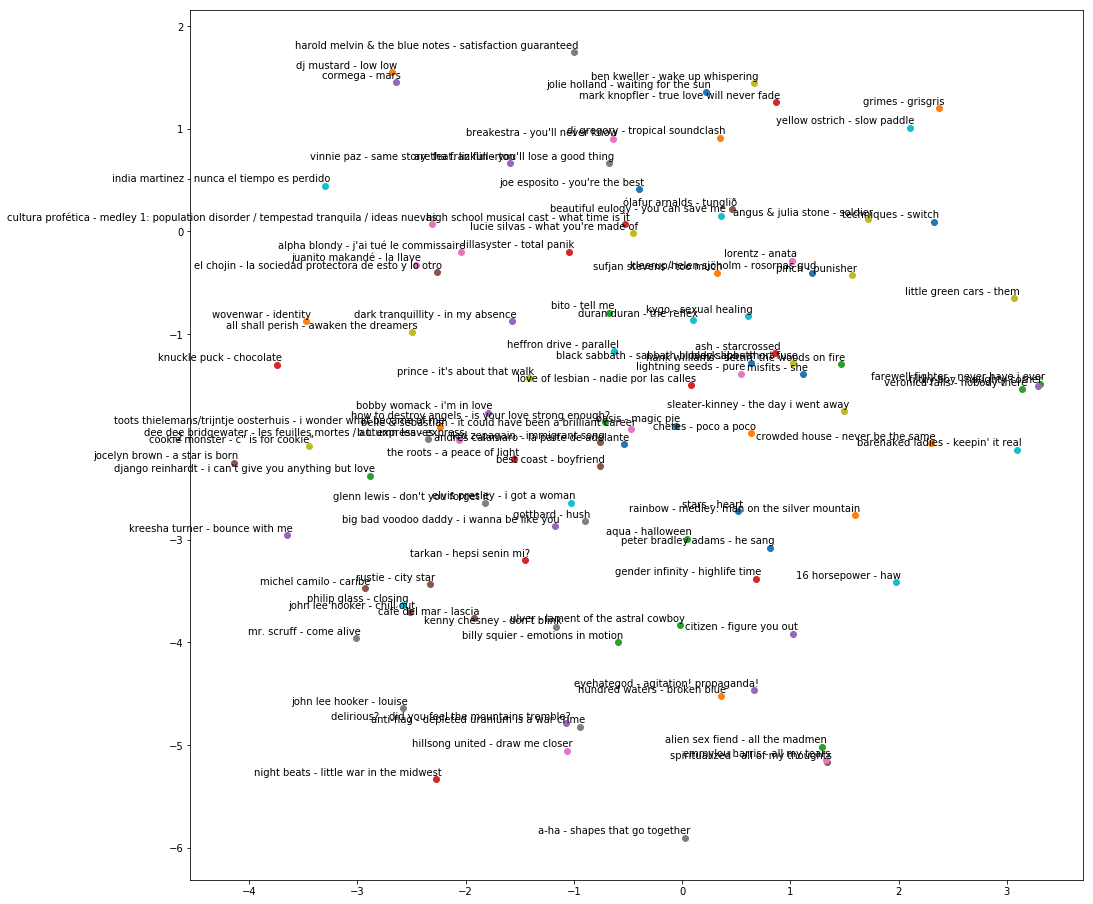

In [148]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 0),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [149]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(train, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.5202300032368005, 0.15291891283641226, 105042, 45707)

In [150]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.4754919219183977, 0.14022477352177087, 25563, 12125)

## Appendix

In [113]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)